In [1]:
# @title **Install Required Packages**
# This cell installs all necessary packages for the project
!pip install transformers torch torchvision faiss-cpu pillow requests matplotlib gradio
print("All required packages installed successfully!")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.4/31.4 MB 25.7 MB/s eta 0:00:00
All required packages installed successfully!


In [2]:
# @title **Import Libraries**
# Import all necessary libraries for the project
import os
import torch
import numpy as np
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt
from transformers import CLIPProcessor, CLIPModel
import faiss
from sklearn.preprocessing import normalize
import zipfile
from pathlib import Path
import random
import gradio as gr

# Check if CUDA is available and set device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


In [3]:
# @title **Extract and Prepare Dataset from ZIP File**
# This cell extracts the Caltech 101 dataset from your downloaded zip file
# Modify the path if your zip file has a different name or location

zip_file_path = "/content/drive/MyDrive/archive.zip"  # Change this if your file has a different name

# Check if the zip file exists
if not os.path.exists(zip_file_path):
    print(f"Error: {zip_file_path} not found!")
    print("Please upload the caltech-101.zip file to your Colab environment first.")
    print("You can use the file upload button on the left sidebar.")
else:
    # Extract the dataset
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall("data")

    print("Dataset extracted successfully!")

    # Check what was extracted
    extracted_path = "data"
    contents = os.listdir(extracted_path)
    print("Contents of data directory:", contents)

Dataset extracted successfully!
Contents of data directory: ['caltech-101']


Using dataset path: data/caltech-101
Found 102 categories
Found 9144 images


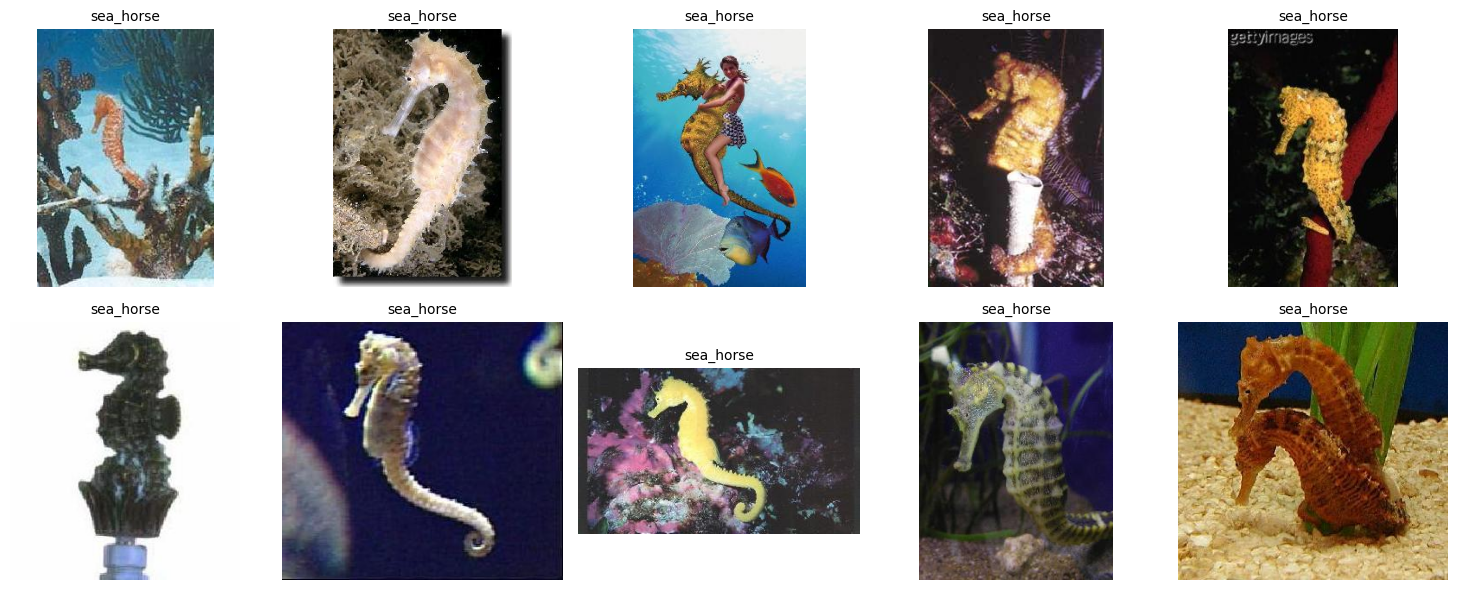

In [4]:
# @title **Find and Explore Dataset**
# This cell finds the actual image directory within the extracted contents
# and explores the dataset structure

def find_image_directory(base_path):
    """Recursively search for the directory containing image categories"""
    for root, dirs, files in os.walk(base_path):
        # Check if this directory contains subdirectories (likely categories)
        if any(os.path.isdir(os.path.join(root, d)) for d in dirs):
            # Check if any of these subdirectories contain images
            for dir_name in dirs:
                dir_path = os.path.join(root, dir_name)
                image_files = [f for f in os.listdir(dir_path)
                             if f.endswith(('.jpg', '.jpeg', '.png'))]
                if image_files:
                    return root
        # Check if this directory directly contains images
        image_files = [f for f in files if f.endswith(('.jpg', '.jpeg', '.png'))]
        if image_files:
            return root
    return None

# Find the directory containing images
dataset_path = find_image_directory("data")

if dataset_path is None:
    # If we can't find it automatically, check common structures
    possible_paths = [
        "data/101_ObjectCategories",
        "data/caltech101/101_ObjectCategories",
        "data/101_ObjectCategories/101_ObjectCategories",
        "data/caltech-101/101_ObjectCategories",
        "data"  # Last resort: check the data directory itself
    ]

    for path in possible_paths:
        if os.path.exists(path):
            dataset_path = path
            break

if dataset_path is None:
    print("Could not find image directory. Please check the extracted contents:")
    !find data -type d | head -10
else:
    print(f"Using dataset path: {dataset_path}")

# Get all image paths
image_paths = []
categories = []

# First, check if we're at the category level or need to go one level deeper
if any(f.endswith(('.jpg', '.jpeg', '.png')) for f in os.listdir(dataset_path)):
    # We're at the category level, get images directly
    for img_name in os.listdir(dataset_path):
        if img_name.endswith(('.jpg', '.jpeg', '.png')):
            image_paths.append(os.path.join(dataset_path, img_name))
            categories.append("Single Category")
else:
    # We're at the parent level, need to go through categories
    for category in os.listdir(dataset_path):
        category_path = os.path.join(dataset_path, category)
        if os.path.isdir(category_path):
            categories.append(category)
            for img_name in os.listdir(category_path):
                if img_name.endswith(('.jpg', '.jpeg', '.png')):
                    image_paths.append(os.path.join(category_path, img_name))

print(f"Found {len(categories)} categories")
print(f"Found {len(image_paths)} images")

# Display some sample images
if image_paths:
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    for i, ax in enumerate(axes.flat):
        if i < len(image_paths):
            img = Image.open(image_paths[i])
            ax.imshow(img)
            ax.axis('off')
            category_name = os.path.basename(os.path.dirname(image_paths[i]))
            ax.set_title(f"{category_name}", fontsize=10)
    plt.tight_layout()
    plt.show()
else:
    print("No images found. Let's explore the directory structure:")
    !find data -name "*.jpg" | head -10
    !find data -name "*.jpeg" | head -10
    !find data -name "*.png" | head -10

In [5]:
# @title **Initialize CLIP Model**
# CLIP (Contrastive Language-Image Pre-training) is a neural network trained on a variety of image-text pairs
# It can understand images in a semantic way, making it perfect for image similarity tasks

# Load CLIP model and processor
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
model = model.to(device)
model.eval()

print("CLIP model loaded successfully!")
print(f"Model is using: {device}")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

CLIP model loaded successfully!
Model is using: cuda


In [6]:
# @title **Define Embedding Generation Function**
# This function takes an image path, processes the image through CLIP, and returns a feature vector (embedding)
# Embeddings are numerical representations that capture the semantic content of images

def get_image_embedding(image_path):
    """Generate embedding for a single image using CLIP"""
    try:
        # Open and convert image to RGB
        image = Image.open(image_path).convert("RGB")

        # Process image through CLIP processor
        inputs = processor(images=image, return_tensors="pt", padding=True)
        inputs = {k: v.to(device) for k, v in inputs.items()}

        # Generate features using CLIP model
        with torch.no_grad():
            image_features = model.get_image_features(**inputs)
            # Normalize features to unit length for cosine similarity
            image_features = image_features / image_features.norm(dim=-1, keepdim=True)

        return image_features.cpu().numpy().astype('float32')
    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        return None

# Test the function with a sample image
if image_paths:
    sample_embedding = get_image_embedding(image_paths[0])
    print(f"Sample embedding shape: {sample_embedding.shape}")
    print(f"Sample embedding norm: {np.linalg.norm(sample_embedding)}")
else:
    print("No images available to test embedding function")

Sample embedding shape: (1, 512)
Sample embedding norm: 0.9999999403953552


In [7]:
# @title **Generate Embeddings for Available Images**
# This cell processes all images in the dataset to create embeddings
# These embeddings will be stored in a FAISS index for efficient similarity search

if not image_paths:
    print("No images found. Please check the dataset extraction.")
else:
    embeddings = []
    valid_image_paths = []

    print("Generating embeddings for dataset images...")
    for i, img_path in enumerate(image_paths):
        if i % 10 == 0:  # Print progress more frequently
            print(f"Processing image {i}/{len(image_paths)}")

        embedding = get_image_embedding(img_path)
        if embedding is not None:
            embeddings.append(embedding)
            valid_image_paths.append(img_path)

    if embeddings:
        embeddings = np.vstack(embeddings)
        print(f"Generated embeddings for {len(valid_image_paths)} images")
        print(f"Embedding shape: {embeddings.shape}")

        # Normalize embeddings for better cosine similarity calculation
        embeddings = normalize(embeddings, axis=1, norm='l2')
        print("Embeddings normalized successfully!")
    else:
        print("No embeddings were generated. Please check your dataset.")

Generating embeddings for dataset images...
Processing image 0/9144
Processing image 10/9144
Processing image 20/9144
Processing image 30/9144
Processing image 40/9144
Processing image 50/9144
Processing image 60/9144
Processing image 70/9144
Processing image 80/9144
Processing image 90/9144
Processing image 100/9144
Processing image 110/9144
Processing image 120/9144
Processing image 130/9144
Processing image 140/9144
Processing image 150/9144
Processing image 160/9144
Processing image 170/9144
Processing image 180/9144
Processing image 190/9144
Processing image 200/9144
Processing image 210/9144
Processing image 220/9144
Processing image 230/9144
Processing image 240/9144
Processing image 250/9144
Processing image 260/9144
Processing image 270/9144
Processing image 280/9144
Processing image 290/9144
Processing image 300/9144
Processing image 310/9144
Processing image 320/9144
Processing image 330/9144
Processing image 340/9144
Processing image 350/9144
Processing image 360/9144
Proce

In [8]:
# @title **Build FAISS Index**
# FAISS (Facebook AI Similarity Search) is a library for efficient similarity search
# It allows us to quickly find the most similar images to a query image

if 'embeddings' in locals() and len(embeddings) > 0:
    # Create FAISS index
    dimension = embeddings.shape[1]
    index = faiss.IndexFlatIP(dimension)  # Inner product index for cosine similarity
    index.add(embeddings)
    print(f"FAISS index built with {index.ntotal} vectors")
    print(f"Index dimension: {dimension}")
else:
    print("Cannot build FAISS index: No embeddings available")

FAISS index built with 9144 vectors
Index dimension: 512


In [11]:
# @title **Fixed Search and Display Functions**
# These functions handle the similarity search and visualization of results

def search_similar_images(query_image_path, top_k=5):
    """Search for similar images to the query image"""
    # Get query embedding
    query_embedding = get_image_embedding(query_image_path)
    if query_embedding is None:
        return [], []

    # Normalize query embedding
    query_embedding = normalize(query_embedding, axis=1, norm='l2')

    # Search in FAISS index
    distances, indices = index.search(query_embedding, top_k)

    # Convert distances to similarity percentages (cosine similarity * 100)
    similarities = (distances[0] * 100).round(2)

    # Get paths of similar images
    similar_image_paths = [valid_image_paths[i] for i in indices[0]]

    return similar_image_paths, similarities

def display_results(query_path, result_paths, similarities):
    """Display query image and similar images with similarity scores"""
    fig, axes = plt.subplots(1, len(result_paths) + 1, figsize=(20, 5))

    # Display query image
    query_img = Image.open(query_path)
    axes[0].imshow(query_img)
    axes[0].set_title("Query Image", fontsize=14, weight='bold')
    axes[0].axis('off')

    # Display similar images
    for i, (path, sim) in enumerate(zip(result_paths, similarities)):
        img = Image.open(path)
        axes[i+1].imshow(img)
        axes[i+1].set_title(f"Similarity: {sim}%", fontsize=14, weight='bold')
        axes[i+1].axis('off')

    plt.tight_layout()
    plt.show()

print("Search and display functions defined successfully!")

Search and display functions defined successfully!


Query image: data/caltech-101/sea_horse/image_0025.jpg


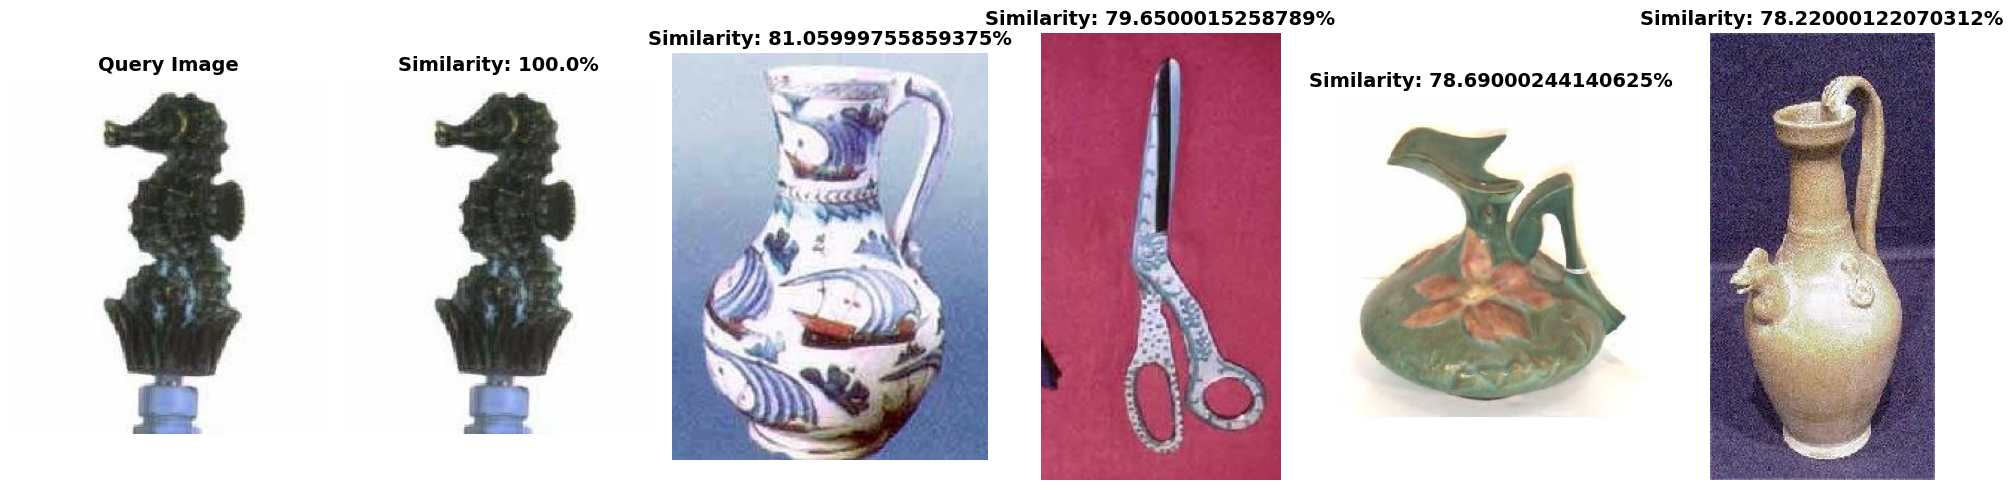

Similarity scores:
Image 1: 100.0%
Image 2: 81.05999755859375%
Image 3: 79.6500015258789%
Image 4: 78.69000244140625%
Image 5: 78.22000122070312%


In [12]:
# @title **Test with Sample Images from Dataset (Fixed)**
# This cell tests the system with sample images from the dataset
# Fixed the ValueError by checking the length of arrays instead of their truth value

if 'valid_image_paths' in locals() and len(valid_image_paths) > 0:
    # Test with a sample image from the dataset
    query_idx = min(5, len(valid_image_paths) - 1)  # Make sure we don't go out of bounds
    query_image = valid_image_paths[query_idx]

    print(f"Query image: {query_image}")
    similar_images, similarities = search_similar_images(query_image, top_k=min(5, len(valid_image_paths)))

    # Check if we have results (fixed the ValueError here)
    if len(similar_images) > 0 and len(similarities) > 0:
        display_results(query_image, similar_images, similarities)

        # Print similarity scores
        print("Similarity scores:")
        for i, sim in enumerate(similarities):
            print(f"Image {i+1}: {sim}%")
    else:
        print("No similar images found or search function not working properly.")
else:
    print("No valid image paths found. Please check your dataset.")

Saving 230911091325-05-invasive-red-fire-ant-europe-italy-ant-macro.jpg to 230911091325-05-invasive-red-fire-ant-europe-italy-ant-macro.jpg
Processing 230911091325-05-invasive-red-fire-ant-europe-italy-ant-macro.jpg...


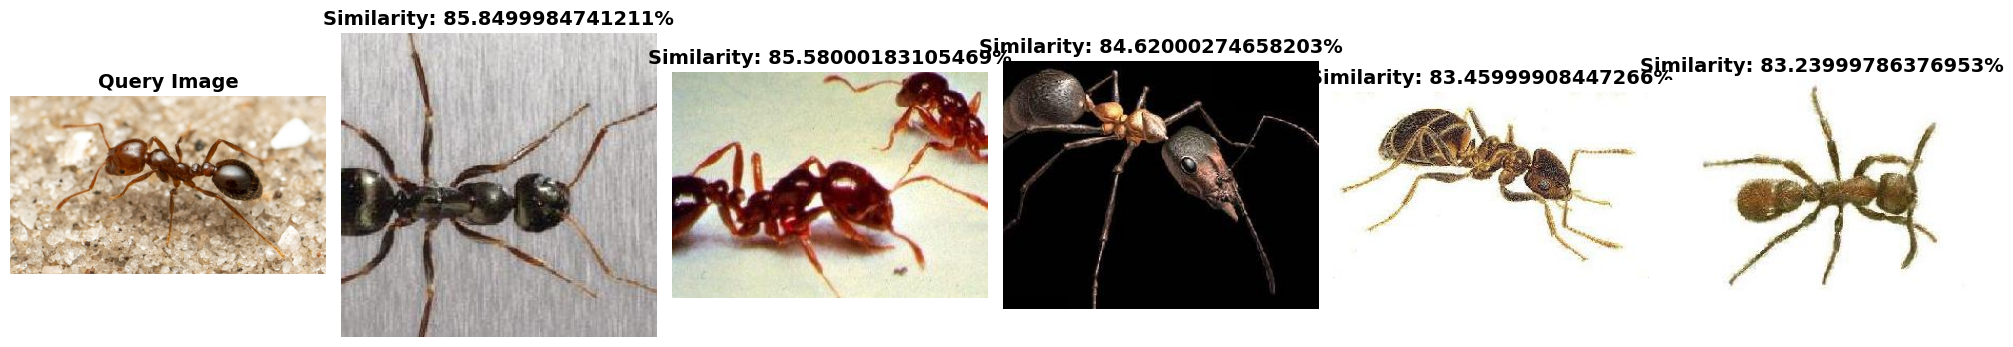

Similarity scores:
Image 1: 85.8499984741211%
Image 2: 85.58000183105469%
Image 3: 84.62000274658203%
Image 4: 83.45999908447266%
Image 5: 83.23999786376953%


In [23]:
# @title **Upload and Test with Custom Images (Robust Version)**
# This version has better error handling and debugging

from google.colab import files

def upload_and_search_robust():
    """Upload an image and search for similar images with better error handling"""
    try:
        uploaded = files.upload()

        for filename in uploaded.keys():
            print(f"Processing {filename}...")

            # Check if file is an image
            if not filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
                print(f"Warning: {filename} doesn't appear to be an image file")
                continue

            similar_images, similarities = search_similar_images(filename, top_k=5)

            # Check if we have valid results
            if (similar_images is not None and similarities is not None and
                len(similar_images) > 0 and len(similarities) > 0):

                display_results(filename, similar_images, similarities)

                # Print similarity scores
                print("Similarity scores:")
                for i, sim in enumerate(similarities):
                    print(f"Image {i+1}: {sim}%")
            else:
                print("No similar images found or search returned empty results.")

    except Exception as e:
        print(f"Error during upload and search: {e}")
        print("Please make sure all previous cells have been executed successfully.")

# Uncomment the line below to upload and test with your own image
upload_and_search_robust()

In [20]:
# @title **Save the FAISS Index and Image Paths**
# Saving the index and paths allows you to reload the system without recomputing all embeddings

try:
    # Check if we have the required components
    if 'index' not in locals():
        print("❌ FAISS index not found. Please run the 'Build FAISS Index' cell first.")
    elif 'valid_image_paths' not in locals():
        print("❌ Valid image paths not found. Please run the 'Generate Embeddings for All Images' cell first.")
    elif len(valid_image_paths) == 0:
        print("❌ No valid image paths available. Please check your dataset and embedding generation.")
    else:
        # Save the FAISS index
        faiss.write_index(index, "image_similarity_index.faiss")
        print("✅ FAISS index saved successfully!")

        # Save the image paths
        with open("image_paths.txt", "w") as f:
            for path in valid_image_paths:
                f.write(f"{path}\n")
        print("✅ Image paths saved successfully!")

        # Save the embeddings as well for completeness
        if 'embeddings' in locals() and len(embeddings) > 0:
            np.save("image_embeddings.npy", embeddings)
            print("✅ Image embeddings saved successfully!")

        print("\n📁 Files saved:")
        print("   - image_similarity_index.faiss (FAISS index)")
        print("   - image_paths.txt (list of image paths)")
        if 'embeddings' in locals() and len(embeddings) > 0:
            print("   - image_embeddings.npy (image embeddings)")

        print("\n📋 To load in future sessions:")
        print("```python")
        print("import numpy as np")
        print("import faiss")
        print("")
        print("# Load FAISS index")
        print("index = faiss.read_index('image_similarity_index.faiss')")
        print("")
        print("# Load image paths")
        print("with open('image_paths.txt', 'r') as f:")
        print("    valid_image_paths = [line.strip() for line in f.readlines()]")
        print("")
        print("# Load embeddings (optional)")
        print("embeddings = np.load('image_embeddings.npy')")
        print("```")

except Exception as e:
    print(f"❌ Error saving files: {e}")
    print("Please check if you have write permissions in the current directory.")

✅ FAISS index saved successfully!
✅ Image paths saved successfully!
✅ Image embeddings saved successfully!

📁 Files saved:
   - image_similarity_index.faiss (FAISS index)
   - image_paths.txt (list of image paths)
   - image_embeddings.npy (image embeddings)

📋 To load in future sessions:
```python
import numpy as np
import faiss

# Load FAISS index
index = faiss.read_index('image_similarity_index.faiss')

# Load image paths
with open('image_paths.txt', 'r') as f:
    valid_image_paths = [line.strip() for line in f.readlines()]

# Load embeddings (optional)
embeddings = np.load('image_embeddings.npy')
```


In [21]:
import numpy as np
import faiss

# Load FAISS index
index = faiss.read_index('image_similarity_index.faiss')

# Load image paths
with open('image_paths.txt', 'r') as f:
    valid_image_paths = [line.strip() for line in f.readlines()]

# Load embeddings (optional)
embeddings = np.load('image_embeddings.npy')

In [22]:
# @title **Conclusion and Future Work**
# This cell summarizes what we've built and suggests possible extensions

print("""
🎉 Image Similarity Detection System Implemented Successfully!

What we've built:
1. A system that uses CLIP to generate semantic image embeddings
2. FAISS for efficient similarity search across images
3. A user interface to query the system and visualize results

Key features:
- Semantic understanding of images (not just pixel similarity)
- Fast retrieval of similar images
- Similarity scores in percentage
- Support for custom image uploads

Future enhancements:
1. Web deployment with Flask/FastAPI
2. Fine-tuning on specific domains (e.g., medical images, products)
3. Video similarity by processing video frames
4. Integration with cloud storage for larger datasets
5. User feedback mechanism to improve results

The system is now ready for your capstone project demonstration!
""")


🎉 Image Similarity Detection System Implemented Successfully!

What we've built:
1. A system that uses CLIP to generate semantic image embeddings
2. FAISS for efficient similarity search across images
3. A user interface to query the system and visualize results

Key features:
- Semantic understanding of images (not just pixel similarity)
- Fast retrieval of similar images
- Similarity scores in percentage
- Support for custom image uploads

Future enhancements:
1. Web deployment with Flask/FastAPI
2. Fine-tuning on specific domains (e.g., medical images, products)
3. Video similarity by processing video frames
4. Integration with cloud storage for larger datasets
5. User feedback mechanism to improve results

The system is now ready for your capstone project demonstration!

